In [7]:
import json
import os
from collections.abc import Sequence

from mlflow.exceptions import RestException
from mlflow.tracking import MlflowClient


In [8]:
from typing import NamedTuple

import jax
import jax.numpy as jnp


class Metric(NamedTuple):
    steps: jax.Array
    values: jax.Array

In [9]:
def download_metrics(run_id: str, metric_keys: Sequence[str]) -> dict[str, Metric]:
    """Downloads metrics of the form "validation/token_loss_{i}" for i in range(100) from a given MLflow run.

    Parameters:
        experiment_id (str): MLflow experiment ID.
        run_id (str): MLflow run ID.
        output_path (str, optional): File path to save the metrics as JSON. If None, does not save to disk.

    Returns:
        dict: Dictionary containing the token loss metrics.
    """
    client = MlflowClient(tracking_uri="databricks")

    metrics = {}
    for key in metric_keys:
        try:
            metric_history = client.get_metric_history(run_id, key)
            metrics[key] = Metric(
                steps=jnp.array([m.step for m in metric_history]),
                values=jnp.array([m.value for m in metric_history]),
            )
        except RestException:
            print(f"Metric {key} not found")
    return metrics

In [10]:
def save_metrics(metrics: dict, output_path: str | None = None) -> None:
    """Save metrics to a JSON file."""
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with open(output_path, "w") as f:
            json.dump(metrics, f, indent=2)
        print(f"Metrics saved to {output_path}")

In [11]:
p = 0.4
q = 0.25
r = 1 - p - q
h = 0.5

min_loss = -q * jnp.log(h)
for v in [p, q, r]:
    min_loss -= v * jnp.log(v)
min_loss /= (1 + 2 * q)

min_loss

Array(0.83587635, dtype=float32, weak_type=True)

## Transformer

In [12]:
run_id = "b71869abbbdc4ff39119fdbce4de2416"
metric_keys = [f"validation/token_loss_{i}" for i in range(100)]
metrics = download_metrics(run_id, metric_keys)
new_metrics: dict[int, Metric] = {int(k.split("_")[-1]): v for k, v in metrics.items() if v.steps.size > 0}
set(range(100)) - set(new_metrics.keys())

{99}

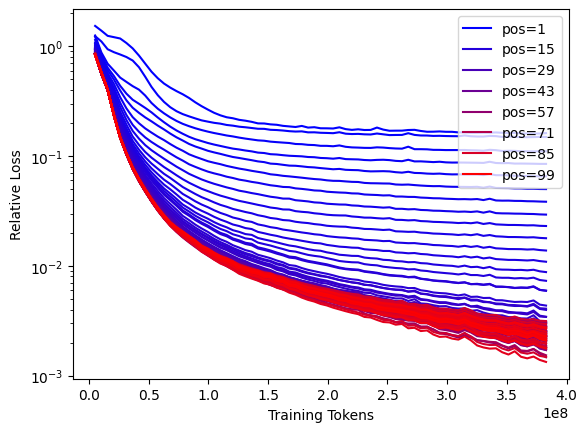

In [13]:
import matplotlib.pyplot as plt

k_max = max(new_metrics.keys())

u = 99
batch_size = 512
sequence_length = 1024
tokens_per_step = batch_size * sequence_length

for k in range(0, u, 1):
    v = new_metrics[k]
    x = v.steps * tokens_per_step
    y = v.values / min_loss - 1
    color = (k / u, 0, 1 - k / u)
    if k % 14 == 0:
        plt.semilogy(x, y, color=color, label=f"pos={k+1}")
    else:
        plt.semilogy(x, y, color=color)

plt.xlabel("Training Tokens")
plt.ylabel("Relative Loss")
plt.legend()
plt.show()


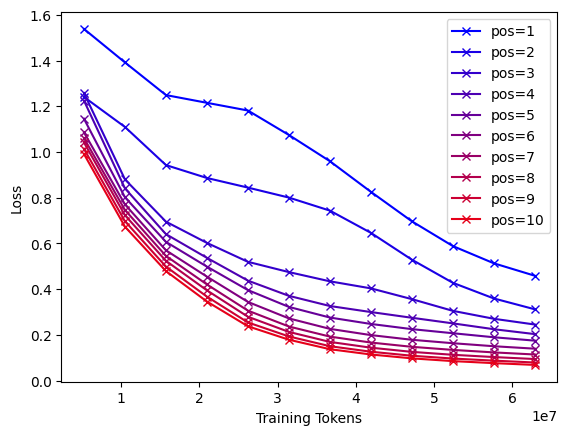

In [14]:
k_max = max(new_metrics.keys())

u = 10
p = 12

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    plt.plot(v.steps[:p] * tokens_per_step, v.values[:p] / min_loss - 1, "-x", color=color, label=f"pos={k+1}")

plt.xlabel("Training Tokens")
plt.ylabel("Loss")
plt.legend()
plt.show()

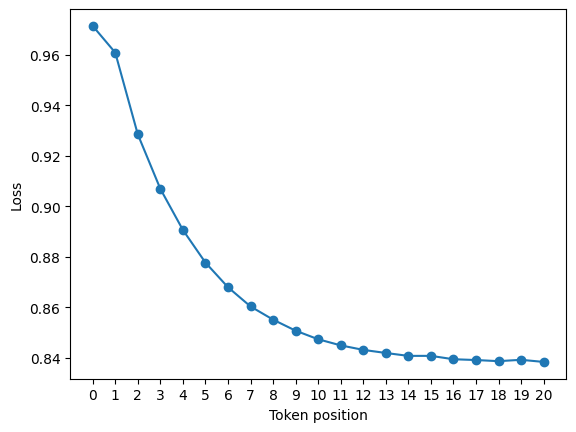

In [15]:
pos = []
loss = []
for k, v in new_metrics.items():
    if v.values.size > 0:
        pos.append(k)
        loss.append(v.values[-1])

plt.plot(jnp.array(pos)[:21], jnp.array(loss)[:21], '-o')
plt.xticks(range(21))
plt.xlabel("Token position")
plt.ylabel("Loss")
plt.show()



## RNN

In [10]:
run_id = "e4ccbc41d48c4e7dbce47c9300c5a62a"
metric_keys = [f"validation/token_loss_{i}" for i in range(100)]
metrics = download_metrics(run_id, metric_keys)
new_metrics: dict[int, Metric] = {int(k.split("_")[-1]): v for k, v in metrics.items() if v.steps.size > 0}
set(range(100)) - set(new_metrics.keys())

{99}

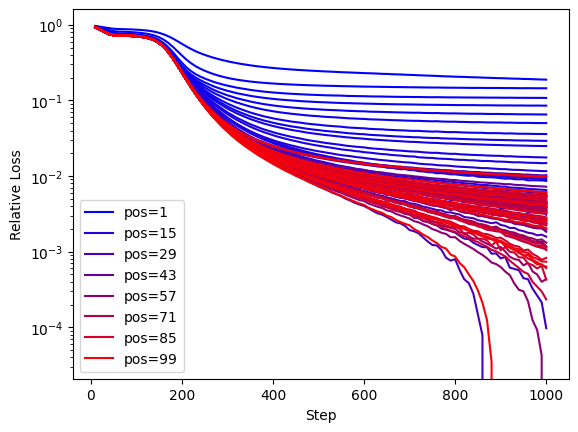

In [11]:
import matplotlib.pyplot as plt

k_max = max(new_metrics.keys())

u = 99

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    if k % 14 == 0:
        plt.semilogy(v.steps, v.values / min_loss - 1, color=color, label=f"pos={k+1}")
    else:
        plt.semilogy(v.steps, v.values / min_loss - 1, color=color)

plt.xlabel("Step")
plt.ylabel("Relative Loss")
plt.legend()
plt.show()

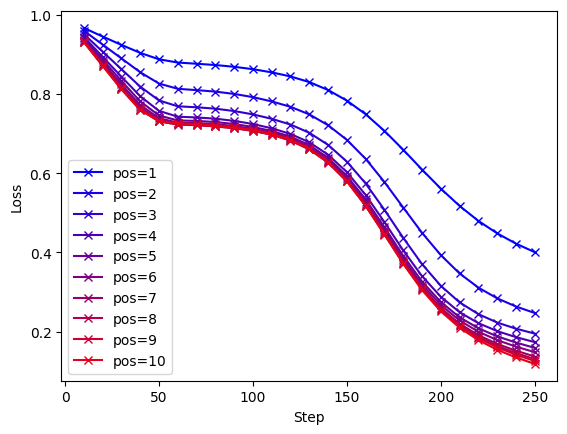

In [14]:
k_max = max(new_metrics.keys())

u = 10
p = 25

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    plt.plot(v.steps[:p], v.values[:p] / min_loss - 1, "-x", color=color, label=f"pos={k+1}")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

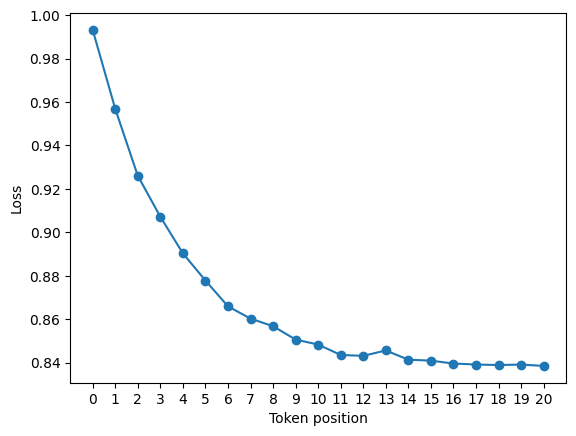

In [15]:
pos = []
loss = []
for k, v in new_metrics.items():
    if v.values.size > 0:
        pos.append(k)
        loss.append(v.values[-1])

plt.plot(jnp.array(pos)[:21], jnp.array(loss)[:21], '-o')
plt.xticks(range(21))
plt.xlabel("Token position")
plt.ylabel("Loss")
plt.show()

In [1]:
import jax.numpy as jnp


metrics = jnp.load("/workspaces/simplexity/metrics.npz")

for k, v in metrics.items():
    print(k, v.shape)


0 (73,)
1 (73,)
2 (73,)
3 (73,)
4 (73,)
5 (73,)
6 (73,)
7 (73,)
8 (73,)
9 (73,)
10 (73,)
11 (73,)
12 (73,)
13 (73,)
14 (73,)
15 (73,)
16 (73,)
17 (73,)
18 (73,)
19 (73,)
20 (73,)
21 (73,)
22 (73,)
23 (73,)
24 (73,)
25 (73,)
26 (73,)
27 (73,)
28 (73,)
29 (73,)
30 (73,)
31 (73,)
32 (73,)
33 (73,)
34 (73,)
35 (73,)
36 (73,)
37 (73,)
38 (73,)
39 (73,)
40 (73,)
41 (73,)
42 (73,)
43 (73,)
44 (73,)
45 (73,)
46 (73,)
47 (73,)
48 (73,)
49 (73,)
50 (73,)
51 (73,)
52 (73,)
53 (73,)
54 (73,)
55 (73,)
56 (73,)
57 (73,)
58 (73,)
59 (73,)
60 (73,)
61 (73,)
62 (73,)
63 (73,)
64 (73,)
65 (73,)
66 (73,)
67 (73,)
68 (73,)
69 (73,)
70 (73,)
71 (73,)
72 (73,)
73 (73,)
74 (73,)
75 (73,)
76 (73,)
77 (73,)
78 (73,)
79 (73,)
80 (73,)
81 (73,)
82 (73,)
83 (73,)
84 (73,)
85 (73,)
86 (73,)
87 (73,)
88 (73,)
89 (73,)
90 (73,)
91 (73,)
92 (73,)
93 (73,)
94 (73,)
95 (73,)
96 (73,)
97 (73,)
98 (73,)
elapsed_training_tokens (73,)
